In [10]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [41]:
df = df[~df["Customer ID"].isna()]
df = df[df["Country"] == "United Kingdom"]

In [42]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [43]:
df["InvoiceDate"] = 100*df["InvoiceDate"].dt.year + df["InvoiceDate"].dt.month

In [44]:
df["Revenue"] = df["Price"] * df["Quantity"]

In [45]:
df_revenue = df.groupby("InvoiceDate")["Revenue"].sum().reset_index()
df_revenue.head()

,InvoiceDate,Revenue
0,200912,592863.130
1,201001,399196.632
2,201002,402813.936
3,201003,549217.831
4,201004,472944.591


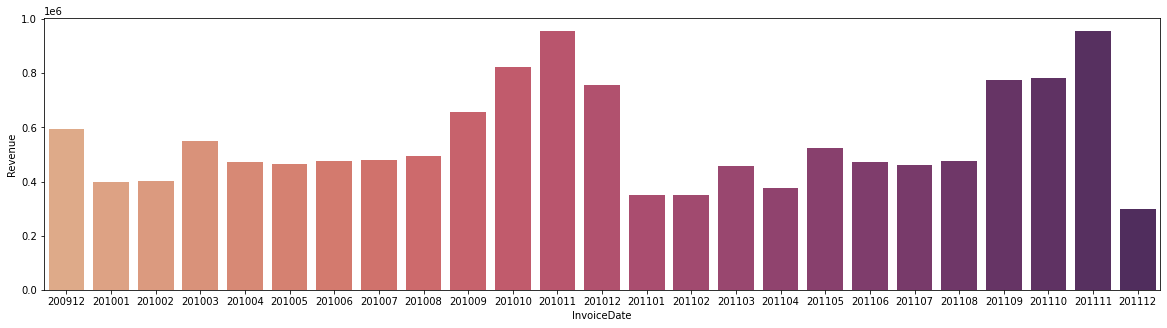

In [46]:
plt.figure(figsize=(20,5))
sns.barplot(x=df_revenue["InvoiceDate"], y=df_revenue["Revenue"], palette="flare")
plt.show()

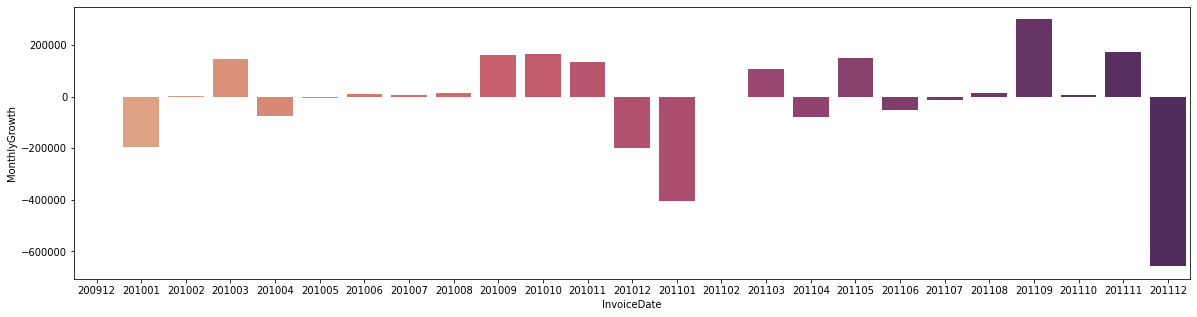

In [47]:
df_revenue["MonthlyGrowth"] = df_revenue["Revenue"] - df_revenue["Revenue"].shift(1)

plt.figure(figsize=(20,5))
sns.barplot(x=df_revenue["InvoiceDate"], y=df_revenue["MonthlyGrowth"], palette="flare")
plt.show()

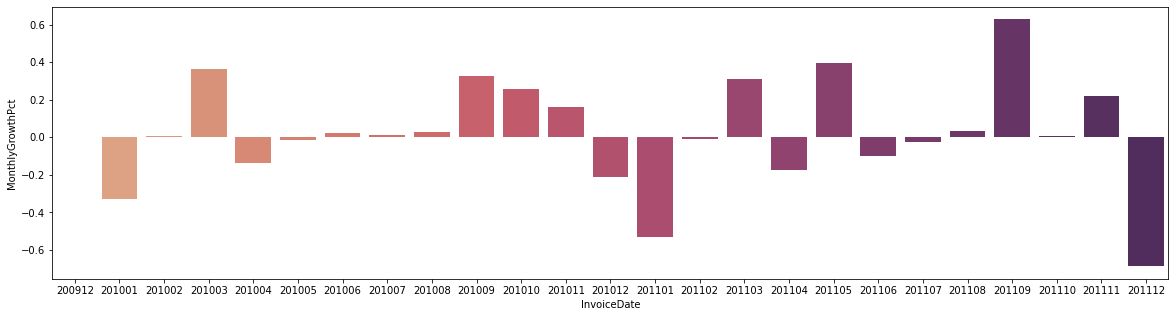

In [48]:
df_revenue["MonthlyGrowthPct"] = df_revenue["Revenue"].pct_change()

plt.figure(figsize=(20,5))
sns.barplot(x=df_revenue["InvoiceDate"], y=df_revenue["MonthlyGrowthPct"], palette="flare")
plt.show()

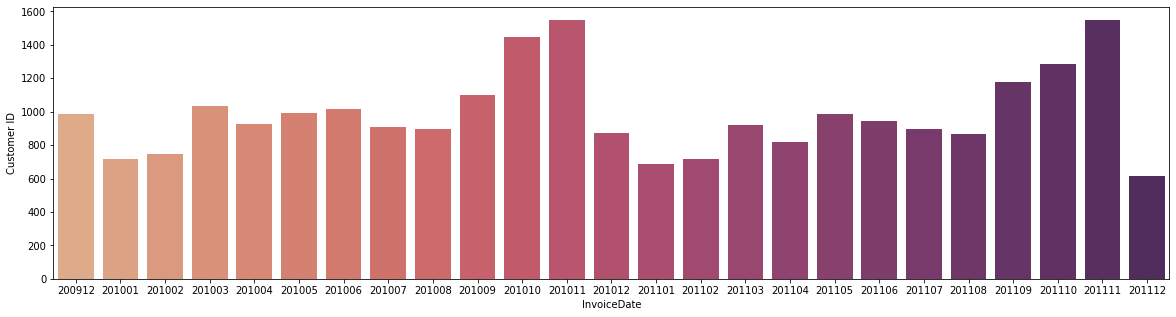

In [49]:
df_monthly_active = df.groupby("InvoiceDate")["Customer ID"].nunique().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=df_monthly_active["InvoiceDate"], y=df_monthly_active["Customer ID"], palette="flare")
plt.show()

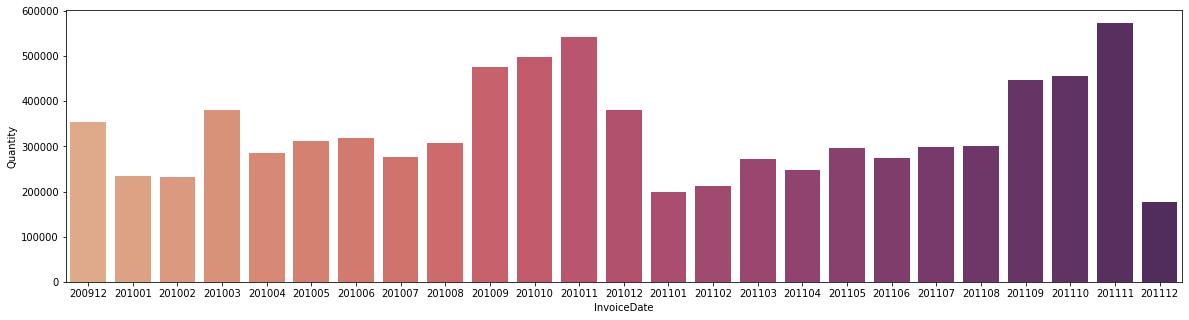

In [50]:
df_monthly_orders = df.groupby("InvoiceDate")["Quantity"].sum().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=df_monthly_orders["InvoiceDate"], y=df_monthly_orders["Quantity"], palette="flare")
plt.show()

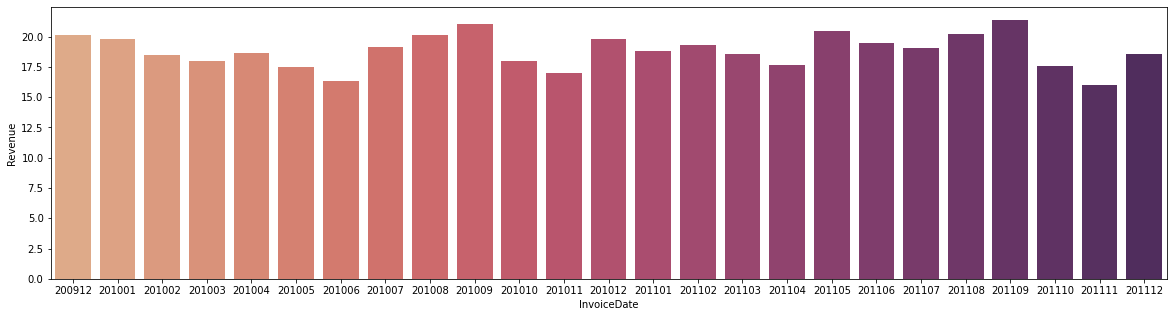

In [51]:
df_monthly_mean_revenue = df.groupby("InvoiceDate")["Revenue"].mean().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=df_monthly_mean_revenue["InvoiceDate"], y=df_monthly_mean_revenue["Revenue"], palette="flare")
plt.show()

In [52]:
df_min_purchase = df.groupby("Customer ID")["InvoiceDate"].min().reset_index().rename(columns={"InvoiceDate": "MinInvoiceDate"})

df = pd.merge(df, df_min_purchase, on="Customer ID")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,MinInvoiceDate
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,200912,6.95,13085.0,United Kingdom,83.4,200912
1,489434,79323P,PINK CHERRY LIGHTS,12,200912,6.75,13085.0,United Kingdom,81.0,200912
2,489434,79323W,WHITE CHERRY LIGHTS,12,200912,6.75,13085.0,United Kingdom,81.0,200912
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,200912,2.10,13085.0,United Kingdom,100.8,200912
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,200912,1.25,13085.0,United Kingdom,30.0,200912


In [53]:
df["UserType"] = "New"
df.loc[df["InvoiceDate"] > df["MinInvoiceDate"], "UserType"] = "Existing"

df_user_type_revenue = df.groupby(["InvoiceDate", "UserType"])["Revenue"].sum().reset_index()
df_user_type_revenue = df_user_type_revenue[(df_user_type_revenue["InvoiceDate"] > df_user_type_revenue["InvoiceDate"].min()) & (df_user_type_revenue["InvoiceDate"] < df_user_type_revenue["InvoiceDate"].max())]

df_user_type_revenue.head()

,InvoiceDate,UserType,Revenue
1,201001,Existing,274612.761
2,201001,New,124583.871
3,201002,Existing,265664.363
4,201002,New,137149.573
5,201003,Existing,388191.630


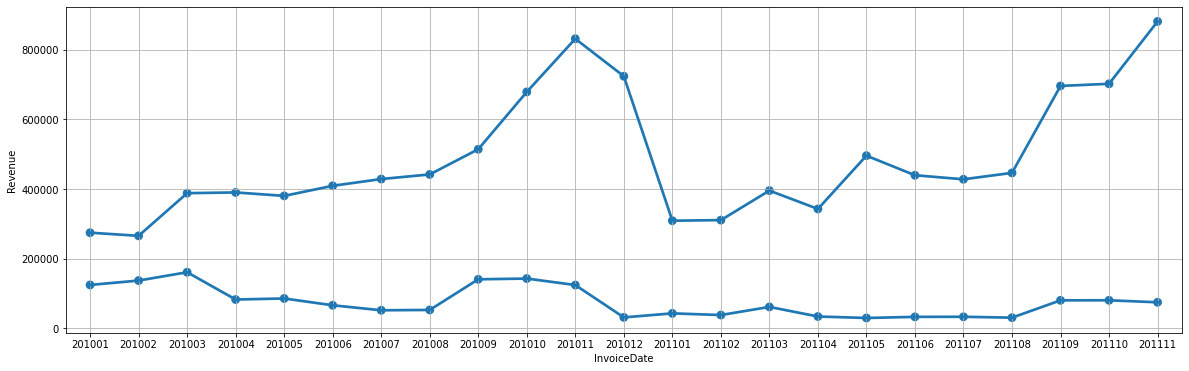

In [74]:
plt.figure(figsize=(20,6))
df_user_type_revenue = df_user_type_revenue.sort_values("InvoiceDate")

sns.pointplot(x=df_user_type_revenue.query("UserType == 'New'")["InvoiceDate"], y=df_user_type_revenue.query("UserType == 'New'")["Revenue"])
sns.pointplot(x=df_user_type_revenue.query("UserType == 'Existing'")["InvoiceDate"], y=df_user_type_revenue.query("UserType == 'Existing'")["Revenue"])

plt.grid()
plt.show()

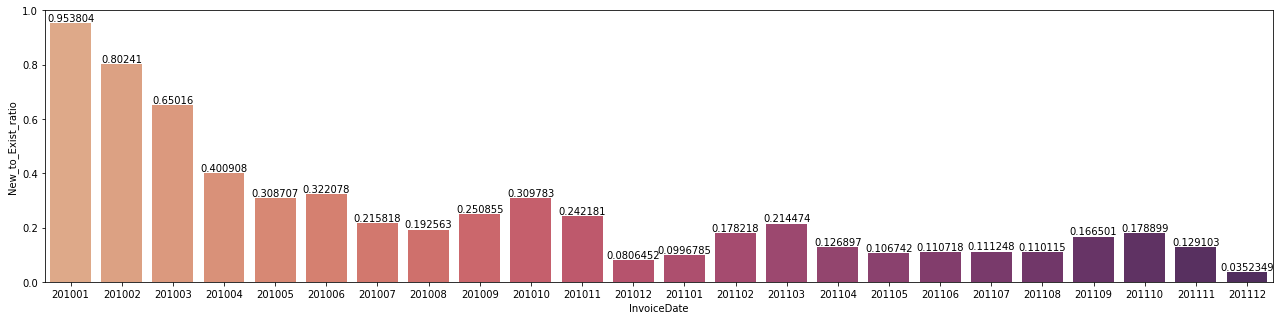

In [84]:
df_user_type_ratio = df[df["UserType"] == "New"].groupby("InvoiceDate")["Customer ID"].nunique() / df[df["UserType"] == "Existing"].groupby("InvoiceDate")["Customer ID"].nunique()
df_user_type_ratio = df_user_type_ratio.reset_index().dropna().rename(columns={"Customer ID": "New_to_Exist_ratio"})

fig, ax = plt.subplots(1, 1, figsize=(22,5))
ax = sns.barplot(x=df_user_type_ratio["InvoiceDate"], y=df_user_type_ratio["New_to_Exist_ratio"], palette="flare", )
ax.bar_label(ax.containers[0])
plt.show()

In [85]:
df_user_purchase = df.groupby(["Customer ID", "InvoiceDate"])["Revenue"].sum().reset_index()
df_retention = pd.crosstab(df_user_purchase["Customer ID"], df_user_purchase["InvoiceDate"]).reset_index()

# clients that retained since last month
df_retention.head()

InvoiceDate,Customer ID,200912,201001,201002,201003,201004,201005,201006,201007,201008,...,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12608.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12745.0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,12746.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12747.0,1,0,1,1,1,1,1,0,1,...,1,0,1,1,0,1,0,1,1,1


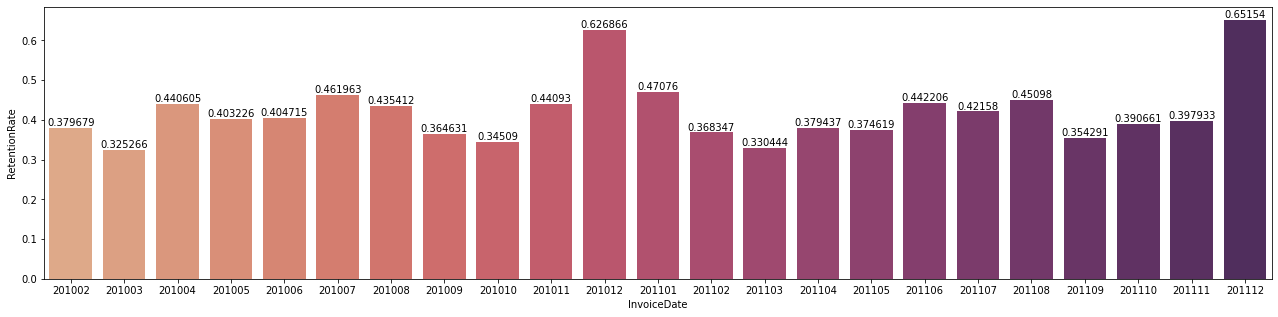

In [86]:
months = df_retention.columns[2:]
retentions = []

for i in range(len(months)-1):
    rdata = {}
    next_month = months[i+1]
    prev_month = months[i]
    rdata["InvoiceDate"] = int(next_month)
    rdata["TotalCustomerCount"] = df_retention[next_month].sum()
    rdata["RetainedCustomers"] = df_retention.loc[(df_retention[next_month] > 0) & (df_retention[prev_month] > 0), next_month].sum()
    retentions.append(rdata)
    
df_retention = pd.DataFrame(retentions)
df_retention["RetentionRate"] = df_retention["RetainedCustomers"] / df_retention["TotalCustomerCount"]

fig, ax = plt.subplots(1, 1, figsize=(22,5))
ax = sns.barplot(x=df_retention["InvoiceDate"], y=df_retention["RetentionRate"], palette="flare", )
ax.bar_label(ax.containers[0])
plt.show()

In [91]:
# retained customers since their first history purchase
df_retention = pd.crosstab(df_user_purchase["Customer ID"], df_user_purchase["InvoiceDate"]).reset_index()
df_retention = pd.merge(df_retention, df_min_purchase[["Customer ID", "MinInvoiceDate"]], on="Customer ID")

df_retention.columns = ['m_' + str(column) for column in df_retention.columns[:-1]] + ["MinInvoiceDate"]

retention = []
for i in range(len(months)):
    rdata = {}
    current_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        rdata[prev_month] = np.nan
    
    total_customers_count = df_retention.loc[df_retention["MinInvoiceDate"] == current_month, "MinInvoiceDate"].count()
    rdata["TotalCustomersCount"] = total_customers_count
    rdata[current_month] = 1
    
    for next_month in next_months:
        condition = (df_retention["MinInvoiceDate"] == current_month) & (df_retention[f"m_{next_month}"] > 0)
        rdata[next_month] = np.round(df_retention.loc[condition, f"m_{next_month}"].sum() / total_customers_count, 2)
        
    retention.append(rdata)
    
df_retention = pd.DataFrame(retention)
df_retention.index = months

df_retention

,TotalCustomersCount,201001,201002,201003,201004,201005,201006,201007,201008,201009,...,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
201001,351,1.0,0.23,0.31,0.32,0.28,0.31,0.27,0.24,0.29,...,0.18,0.15,0.22,0.19,0.17,0.19,0.25,0.19,0.23,0.07
201002,333,NaN,1.00,0.29,0.22,0.31,0.26,0.22,0.21,0.28,...,0.19,0.14,0.20,0.18,0.17,0.14,0.23,0.25,0.15,0.06
201003,407,NaN,NaN,1.00,0.22,0.27,0.24,0.24,0.21,0.25,...,0.19,0.16,0.19,0.17,0.18,0.16,0.17,0.21,0.21,0.08
201004,265,NaN,NaN,NaN,1.00,0.23,0.20,0.16,0.19,0.22,...,0.14,0.14,0.15,0.15,0.15,0.14,0.15,0.16,0.21,0.07
201005,234,NaN,NaN,NaN,NaN,1.00,0.19,0.18,0.20,0.19,...,0.12,0.13,0.15,0.16,0.09,0.12,0.14,0.17,0.15,0.05
201006,248,NaN,NaN,NaN,NaN,NaN,1.00,0.20,0.20,0.21,...,0.12,0.10,0.15,0.15,0.12,0.11,0.10,0.13,0.21,0.06
201007,161,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.20,0.19,...,0.12,0.12,0.11,0.16,0.12,0.13,0.20,0.17,0.24,0.09
201008,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.23,...,0.14,0.14,0.14,0.12,0.13,0.17,0.19,0.19,0.19,0.06
201009,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,...,0.15,0.10,0.13,0.14,0.14,0.10,0.20,0.19,0.18,0.05


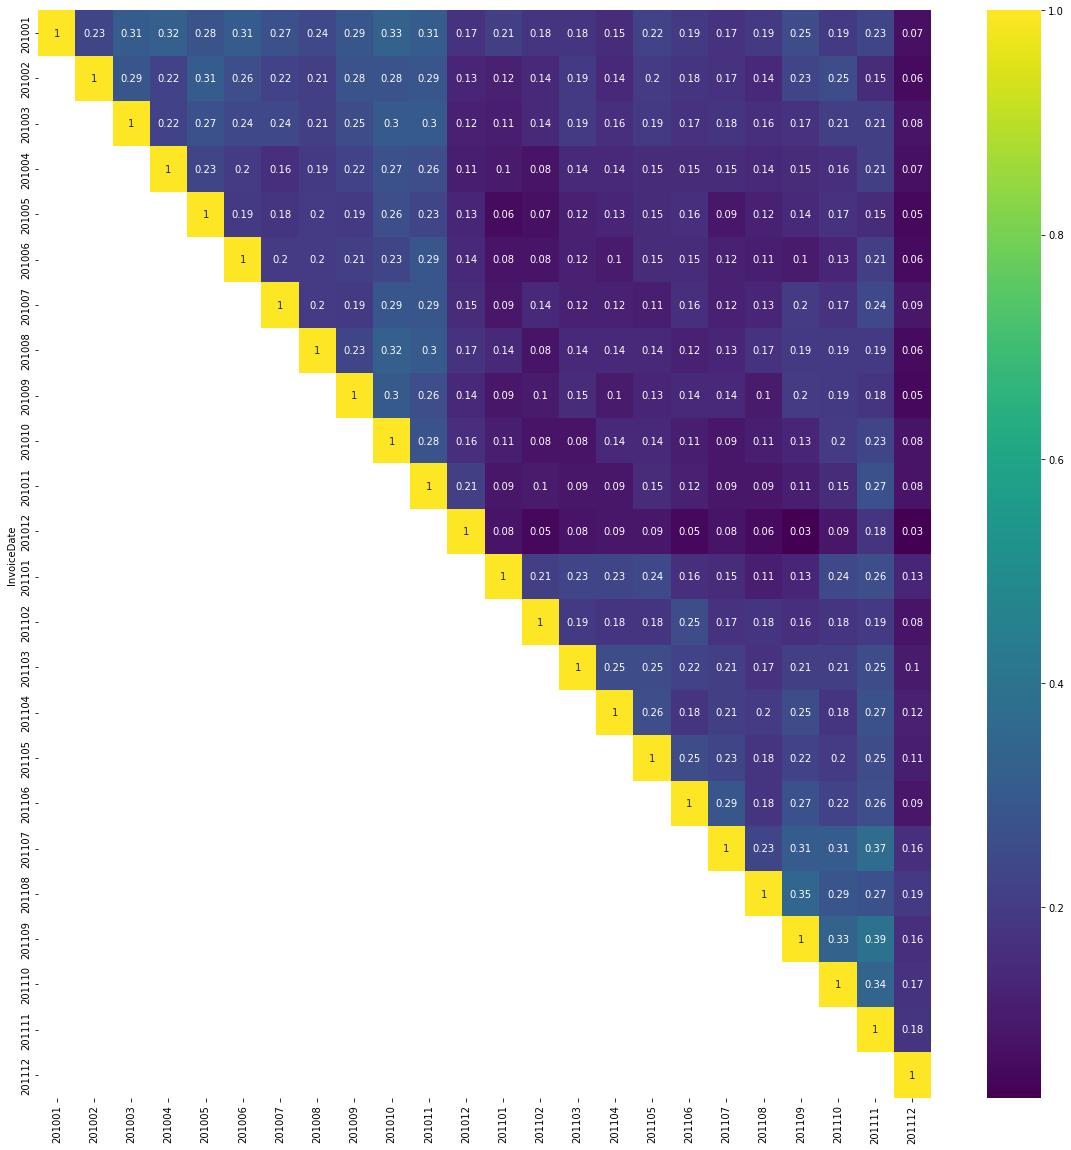

In [94]:
# mask = np.zeros_like(df_retention, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,20))

sns.heatmap(df_retention.iloc[:, 1:], cmap="viridis", annot=True)
plt.show()

In [ ]:
# next segmenting customers by recency (number of days since last purchase), frequency (total number of orders), revenue (sum of all orders) using clustering algorithms